In [1]:
import sys
import os
sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')
from helper_functions import setup_logger, load_procesed_data
# Set up logger
log = setup_logger("Lee_ml_pipeline_run", log_file=os.path.join("logs", "Lee_full_dataset_ml_run_cleaned_atar.log"))

import sys
sys.path.append('c:\\Users\\rokas\\Documents\\Github\\BCI\\mi-bci\\code')
from helper_functions import setup_logger
from helper_functions.data_procesing.mi_procesing import process_mi_raw
import matplotlib.pyplot as plt
from helper_functions import setup_logger, load_procesed_data
from datasets import Lee2019
import os
import glob
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from datasets import Lee2019

log = setup_logger("Lee_preprocess")

dataset = Lee2019()
dataset_no = 20
subject = 10
run = 1
paradigm = "MI"
tmin = -5
tmax = 10
event_id = dict(left_hand=2, right_hand=1)


In [2]:
def clean_results(paths):
    evaluations = {}
    cross_evaluations = {}

    for path in paths:
        filename = os.path.basename(path)
        subject = filename.split('_')[-3]
        file = pd.read_pickle(path)
        file_run_cross = file['cross_session']
        cross_evaluations[subject] = file_run_cross
        
        for run in [1,2]:
            file_run = file['within_session'][run]
            file_run.pop('single_pipeline')
            subject_run = subject + '_' + str(run)
            evaluations[subject_run] = file_run
            
    records = []
    records_cross = []
    # rename loop var so we don't overwrite `records` itself
    for recs, evaluation in zip([records, records_cross],
                                [evaluations, cross_evaluations]):
        for eval_date, pipelines in evaluation.items():
            for pipeline, metrics in pipelines.items():
                record = {'evaluation': eval_date, 'pipeline': pipeline}
                for key, value in metrics.items():
                    if isinstance(value, dict):
                        for subkey, subvalue in value.items():
                            record[f"{key}_{subkey}"] = subvalue
                    else:
                        record[key] = value
                recs.append(record)

    df = pd.DataFrame(records)
    df_cross = pd.DataFrame(records_cross)

    metrics = ['train_accuracy', 'train_roc_auc', 'val_accuracy', 'val_roc_auc']

    # Expand each metric column: convert each list in the column into separate columns.
    for col in metrics:
        # Convert the list values into a DataFrame. Each row's list becomes a row in the new DataFrame.
        expanded = pd.DataFrame(df[col].tolist(), index=df.index)
        # Rename the new columns to include the metric name (e.g. train_accuracy_0, train_accuracy_1, ...)
        expanded = expanded.add_prefix(col + '_')
        # Drop the original list column and join the new expanded columns.
        df = df.drop(columns=[col]).join(expanded)

    # Now, to reorder the columns so that for each pass the four metrics are together:
    # First, determine the number of passes from one of the expanded metric columns.
    n_passes = df.filter(regex=r'^train_accuracy_').shape[1]

    # Collect the metric columns in the order: first pass, second pass, etc.
    ordered_metric_cols = []
    for i in range(n_passes):
        for metric in metrics:
            col_name = f"{metric}_{i}"
            if col_name in df.columns:
                ordered_metric_cols.append(col_name)

    # Get the non-expanded columns (e.g. evaluation, pipeline, etc.)
    other_cols = [col for col in df.columns if not any(col.startswith(m + '_') for m in metrics)]

    # Create the final DataFrame with the desired column order:
    # identifiers first, then the grouped metric columns.
    df = df[other_cols + ordered_metric_cols]

    df_within = df[['evaluation', 'pipeline', 'mean_train_accuracy', 'mean_train_auc','mean_val_accuracy','mean_val_auc']]
    df_cross = df_cross[['evaluation', 'pipeline', 'test_accuracy', 'test_roc_auc']]
    
    return df_within, df_cross

In [3]:
results = {}

df_within, df_cross = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-25\*.pkl'))
results['2025-04-25'] = {'within': df_within, 'cross': df_cross}

df_within_autoreject, df_cross_autoreject = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-25_autoreject\*.pkl'))
results['2025-04-25_autoreject'] = {'within': df_within_autoreject, 'cross': df_cross_autoreject}

df_within_atar_beta0_1_OptModeelim, df_cross_atar_beta0_1_OptModeelim = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.1_OptModeelim\*.pkl'))
results['2025-04-22_atar_beta0.1_OptModeelim'] = {'within': df_within_atar_beta0_1_OptModeelim, 'cross': df_cross_atar_beta0_1_OptModeelim}

df_within_atar_beta0_01_OptModeelim, df_cross_atar_beta0_01_OptModeelim = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.01_OptModeelim\*.pkl'))
results['2025-04-22_atar_beta0.01_OptModeelim'] = {'within': df_within_atar_beta0_01_OptModeelim, 'cross': df_cross_atar_beta0_01_OptModeelim}

df_within_atar_beta0_1_OptModelinAtten, df_cross_atar_beta0_1_OptModelinAtten = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.1_OptModelinAtten\*.pkl'))
results['2025-04-22_atar_beta0.1_OptModelinAtten'] = {'within': df_within_atar_beta0_1_OptModelinAtten, 'cross': df_cross_atar_beta0_1_OptModelinAtten}

df_within_atar_beta0_01_OptModelinAtten, df_cross_atar_beta0_01_OptModelinAtten = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.01_OptModelinAtten\*.pkl'))
results['2025-04-22_atar_beta0.01_OptModelinAtten'] = {'within': df_within_atar_beta0_01_OptModelinAtten, 'cross': df_cross_atar_beta0_01_OptModelinAtten}

df_within_atar_beta0_1_OptModesoft, df_cross_atar_beta0_1_OptModesoft = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.1_OptModesoft\*.pkl'))
results['2025-04-22_atar_beta0.1_OptModesoft'] = {'within': df_within_atar_beta0_1_OptModesoft, 'cross': df_cross_atar_beta0_1_OptModesoft}

df_within_atar_beta0_01_OptModesoft, df_cross_atar_beta0_01_OptModesoft = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.01_OptModesoft\*.pkl'))
results['2025-04-22_atar_beta0.01_OptModesoft'] = {'within': df_within_atar_beta0_01_OptModesoft, 'cross': df_cross_atar_beta0_01_OptModesoft}

df_within_atar_beta0_2_OptModeelim, df_cross_atar_beta0_2_OptModeelim = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.2_OptModeelim\*.pkl'))
results['2025-04-22_atar_beta0.2_OptModeelim'] = {'within': df_within_atar_beta0_2_OptModeelim, 'cross': df_cross_atar_beta0_2_OptModeelim}

df_within_atar_beta0_2_OptModelinAtten, df_cross_atar_beta0_2_OptModelinAtten = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.2_OptModelinAtten\*.pkl'))
results['2025-04-22_atar_beta0.2_OptModelinAtten'] = {'within': df_within_atar_beta0_2_OptModelinAtten, 'cross': df_cross_atar_beta0_2_OptModelinAtten}

df_within_atar_beta0_2_OptModesoft, df_cross_atar_beta0_2_OptModesoft = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.2_OptModesoft\*.pkl'))
results['2025-04-22_atar_beta0.2_OptModesoft'] = {'within': df_within_atar_beta0_2_OptModesoft, 'cross': df_cross_atar_beta0_2_OptModesoft}

df_within_atar_beta0_5_OptModeelim, df_cross_atar_beta0_5_OptModeelim = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.5_OptModeelim\*.pkl'))
results['2025-04-22_atar_beta0.5_OptModeelim'] = {'within': df_within_atar_beta0_5_OptModeelim, 'cross': df_cross_atar_beta0_5_OptModeelim}

df_within_atar_beta0_05_OptModeelim, df_cross_atar_beta0_05_OptModeelim = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.05_OptModeelim\*.pkl'))
results['2025-04-22_atar_beta0.05_OptModeelim'] = {'within': df_within_atar_beta0_05_OptModeelim, 'cross': df_cross_atar_beta0_05_OptModeelim}

df_within_atar_beta0_5_OptModelinAtten, df_cross_atar_beta0_5_OptModelinAtten = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.5_OptModelinAtten\*.pkl'))
results['2025-04-22_atar_beta0.5_OptModelinAtten'] = {'within': df_within_atar_beta0_5_OptModelinAtten, 'cross': df_cross_atar_beta0_5_OptModelinAtten}

df_within_atar_beta0_05_OptModelinAtten, df_cross_atar_beta0_05_OptModelinAtten = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.05_OptModelinAtten\*.pkl'))
results['2025-04-22_atar_beta0.05_OptModelinAtten'] = {'within': df_within_atar_beta0_05_OptModelinAtten, 'cross': df_cross_atar_beta0_05_OptModelinAtten}

df_within_atar_beta0_5_OptModesoft, df_cross_atar_beta0_5_OptModesoft = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.5_OptModesoft\*.pkl'))
results['2025-04-22_atar_beta0.5_OptModesoft'] = {'within': df_within_atar_beta0_5_OptModesoft, 'cross': df_cross_atar_beta0_5_OptModesoft}

df_within_atar_beta0_05_OptModesoft, df_cross_atar_beta0_05_OptModesoft = clean_results(glob.glob(r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019\2025-04-22_atar_beta0.05_OptModesoft\*.pkl'))
results['2025-04-22_atar_beta0.05_OptModesoft'] = {'within': df_within_atar_beta0_05_OptModesoft, 'cross': df_cross_atar_beta0_05_OptModesoft}


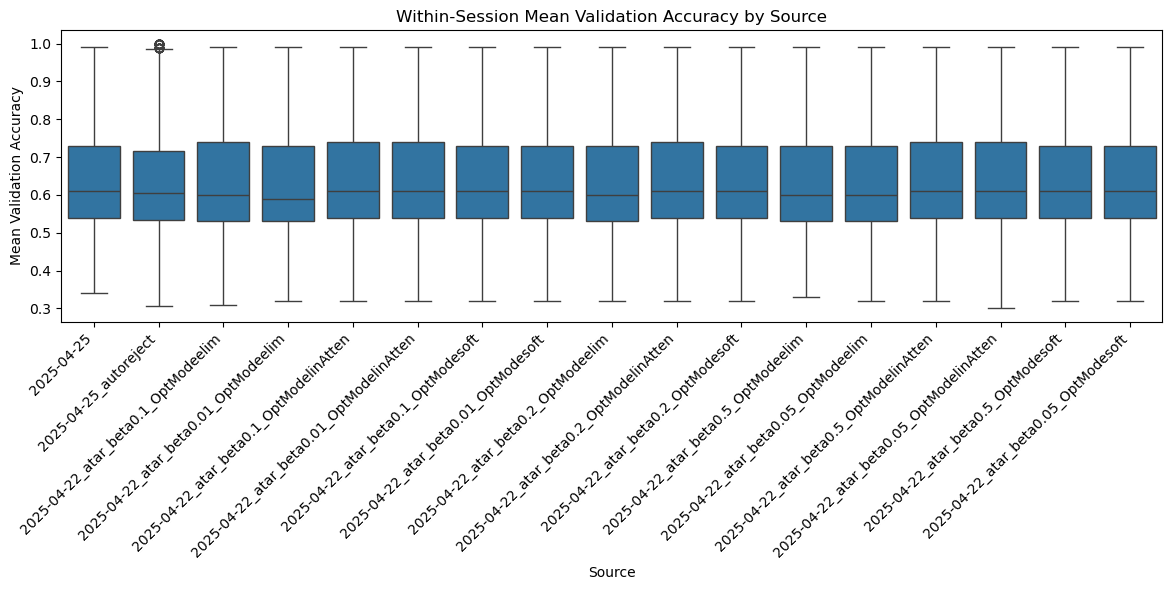

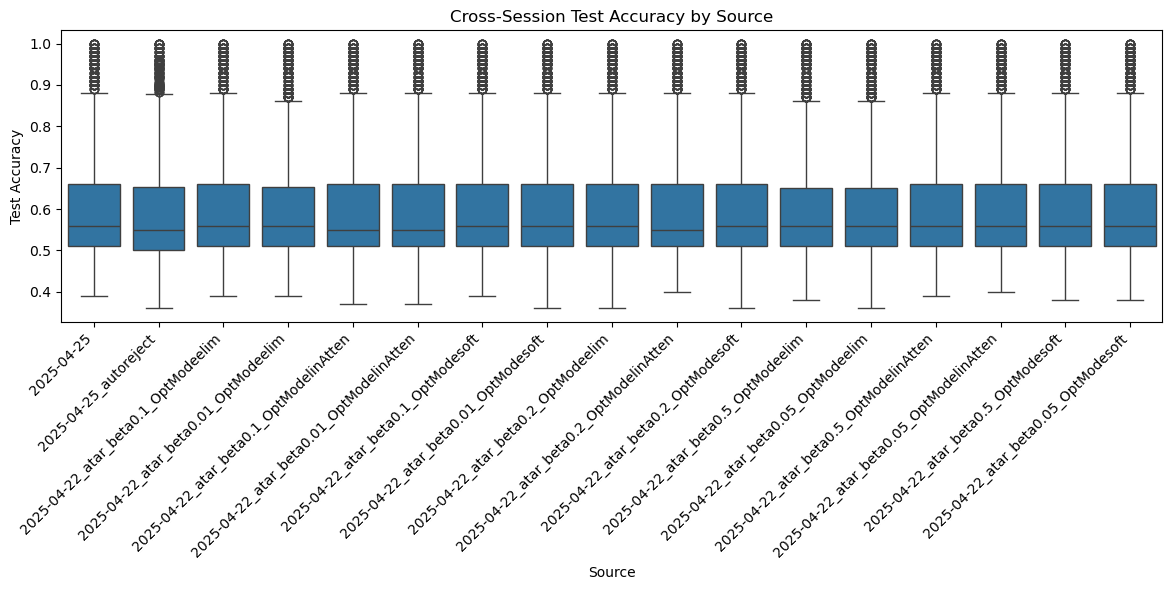

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine within-session DataFrames
within_list = [
    dfs['within'].assign(source=src)
    for src, dfs in results.items()
]
df_within_all = pd.concat(within_list, ignore_index=True)

# Plot within-session boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='source', y='mean_val_accuracy', data=df_within_all)
plt.title("Within-Session Mean Validation Accuracy by Source")
plt.xlabel("Source")
plt.ylabel("Mean Validation Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Combine cross-session DataFrames
cross_list = [
    dfs['cross'].assign(source=src)
    for src, dfs in results.items()
]
df_cross_all = pd.concat(cross_list, ignore_index=True)

# Plot cross-session boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='source', y='test_accuracy', data=df_cross_all)
plt.title("Cross-Session Test Accuracy by Source")
plt.xlabel("Source")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# build a list of summary rows
rows = []
for src, dfs in results.items():
    mean_within = dfs['within']['mean_val_accuracy'].mean()
    mean_cross  = dfs['cross']['test_accuracy'].mean()
    rows.append({
        'source': src,
        'within_mean_val_accuracy': mean_within,
        'cross_mean_test_accuracy': mean_cross
    })

# assemble into a DataFrame, indexed by source
mean_table = pd.DataFrame(rows).set_index('source').sort_index()
print(mean_table)


                                          within_mean_val_accuracy  \
source                                                               
2025-04-22_atar_beta0.01_OptModeelim                      0.638558   
2025-04-22_atar_beta0.01_OptModelinAtten                  0.647845   
2025-04-22_atar_beta0.01_OptModesoft                      0.646822   
2025-04-22_atar_beta0.05_OptModeelim                      0.639065   
2025-04-22_atar_beta0.05_OptModelinAtten                  0.647885   
2025-04-22_atar_beta0.05_OptModesoft                      0.646918   
2025-04-22_atar_beta0.1_OptModeelim                       0.643608   
2025-04-22_atar_beta0.1_OptModelinAtten                   0.647935   
2025-04-22_atar_beta0.1_OptModesoft                       0.647022   
2025-04-22_atar_beta0.2_OptModeelim                       0.639784   
2025-04-22_atar_beta0.2_OptModelinAtten                   0.647922   
2025-04-22_atar_beta0.2_OptModesoft                       0.647374   
2025-04-22_atar_beta

In [42]:
mean_table

,within_mean_val_accuracy,cross_mean_test_accuracy
source,,
2025-04-25,0.647025,0.604781
2025-04-25_autoreject,0.636941,0.592933
2025-04-22_atar_beta0.1_OptModeelim,0.643608,0.609362
2025-04-22_atar_beta0.01_OptModeelim,0.638558,0.604493
2025-04-22_atar_beta0.1_OptModelinAtten,0.647935,0.606277
2025-04-22_atar_beta0.01_OptModelinAtten,0.647845,0.606132
2025-04-22_atar_beta0.1_OptModesoft,0.647022,0.607083
2025-04-22_atar_beta0.01_OptModesoft,0.646822,0.606405
2025-04-22_atar_beta0.2_OptModeelim,0.639784,0.603643


In [6]:
import glob
import pandas as pd

# 1) Reload all results into a dict (after defining clean_results)
base = r'C:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\results\pipeline_scores\lee2019'
folders = [
    '2025-04-25',
    '2025-04-25_autoreject',
    '2025-04-22_atar_beta0.1_OptModeelim',
    '2025-04-22_atar_beta0.01_OptModeelim',
    '2025-04-22_atar_beta0.1_OptModelinAtten',
    '2025-04-22_atar_beta0.01_OptModelinAtten',
    '2025-04-22_atar_beta0.1_OptModesoft',
    '2025-04-22_atar_beta0.01_OptModesoft',
    '2025-04-22_atar_beta0.2_OptModeelim',
    '2025-04-22_atar_beta0.2_OptModelinAtten',
    '2025-04-22_atar_beta0.2_OptModesoft',
    '2025-04-22_atar_beta0.5_OptModeelim',
    '2025-04-22_atar_beta0.05_OptModeelim',
    '2025-04-22_atar_beta0.5_OptModelinAtten',
    '2025-04-22_atar_beta0.05_OptModelinAtten',
    '2025-04-22_atar_beta0.5_OptModesoft',
    '2025-04-22_atar_beta0.05_OptModesoft',
]

results = {}
for folder in folders:
    paths = glob.glob(f"{base}\\{folder}\\*.pkl")
    df_w, df_c = clean_results(paths)
    results[folder] = {'within': df_w, 'cross': df_c}

# 2) Build a table of mean accuracies
rows = []
for src, dfs in results.items():
    rows.append({
        'source': src,
        'within_mean_val_accuracy': dfs['within']['mean_val_accuracy'].mean(),
        'cross_mean_test_accuracy': dfs['cross']['test_accuracy'].mean()
    })

mean_table = pd.DataFrame(rows).set_index('source').sort_index()

# Show the full table
print("\nAll sources mean accuracies:\n")
print(mean_table)

# 3) Filter only the ATAR variants and sort by cross-session accuracy
atar_table = mean_table.loc[mean_table.index.str.contains('atar')]
atar_sorted = atar_table.sort_values('cross_mean_test_accuracy', ascending=False)

# Display the ATAR subset
print("\nATAR configurations (sorted by cross-session mean test accuracy):\n")
print(atar_sorted)

# 4) Print the best ATAR
best_src = atar_sorted.index[0]
best_within = atar_sorted.loc[best_src, 'within_mean_val_accuracy']
best_cross = atar_sorted.loc[best_src, 'cross_mean_test_accuracy']
print(f"\nBest ATAR variant: {best_src}")
print(f"  • Within-session mean val accuracy: {best_within:.3f}")
print(f"  • Cross-session mean test accuracy: {best_cross:.3f}")



All sources mean accuracies:

                                          within_mean_val_accuracy  \
source                                                               
2025-04-22_atar_beta0.01_OptModeelim                      0.638558   
2025-04-22_atar_beta0.01_OptModelinAtten                  0.647845   
2025-04-22_atar_beta0.01_OptModesoft                      0.646822   
2025-04-22_atar_beta0.05_OptModeelim                      0.639065   
2025-04-22_atar_beta0.05_OptModelinAtten                  0.647885   
2025-04-22_atar_beta0.05_OptModesoft                      0.646918   
2025-04-22_atar_beta0.1_OptModeelim                       0.643608   
2025-04-22_atar_beta0.1_OptModelinAtten                   0.647935   
2025-04-22_atar_beta0.1_OptModesoft                       0.647022   
2025-04-22_atar_beta0.2_OptModeelim                       0.639784   
2025-04-22_atar_beta0.2_OptModelinAtten                   0.647922   
2025-04-22_atar_beta0.2_OptModesoft                       0

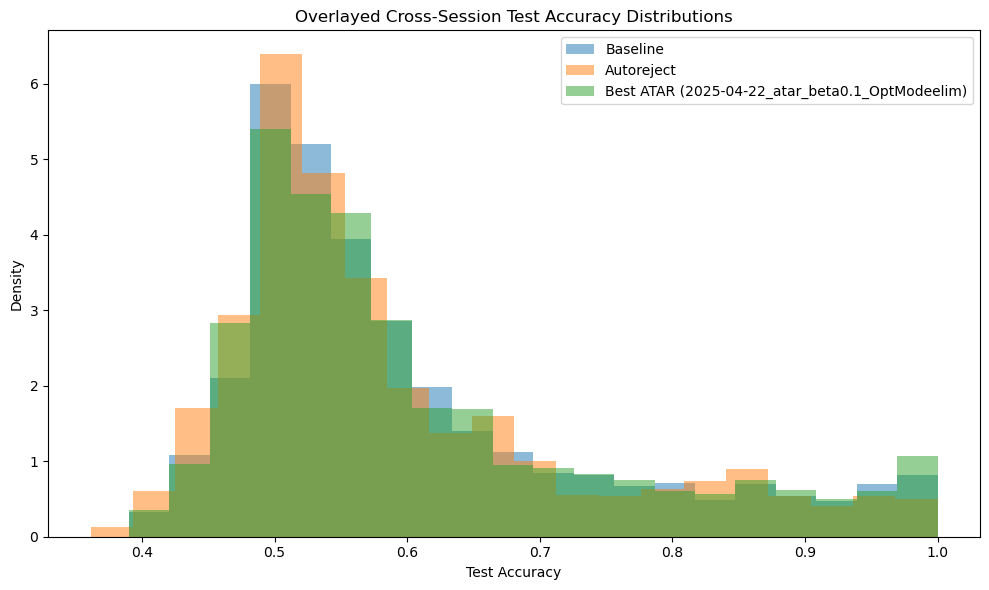

In [7]:
import matplotlib.pyplot as plt

# 1) Re-identify the best ATAR variant
atar_means = {
    src: dfs['cross']['test_accuracy'].mean()
    for src, dfs in results.items()
    if 'atar' in src
}
best_atar_src = max(atar_means, key=atar_means.get)

# 2) Extract the three distributions
baseline = results['2025-04-25']['cross']['test_accuracy']
autoreject = results['2025-04-25_autoreject']['cross']['test_accuracy']
best_atar_data = results[best_atar_src]['cross']['test_accuracy']

# 3) Plot overlayed histograms (density)
plt.figure(figsize=(10, 6))
plt.hist(baseline, bins=20, density=True, alpha=0.5, label='Baseline')
plt.hist(autoreject, bins=20, density=True, alpha=0.5, label='Autoreject')
plt.hist(best_atar_data, bins=20, density=True, alpha=0.5, label=f'Best ATAR ({best_atar_src})')
plt.legend()
plt.title('Overlayed Cross-Session Test Accuracy Distributions')
plt.xlabel('Test Accuracy')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


2025-04-30 21:54:03,752 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:03,755 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:03,758 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:03,758 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:03,

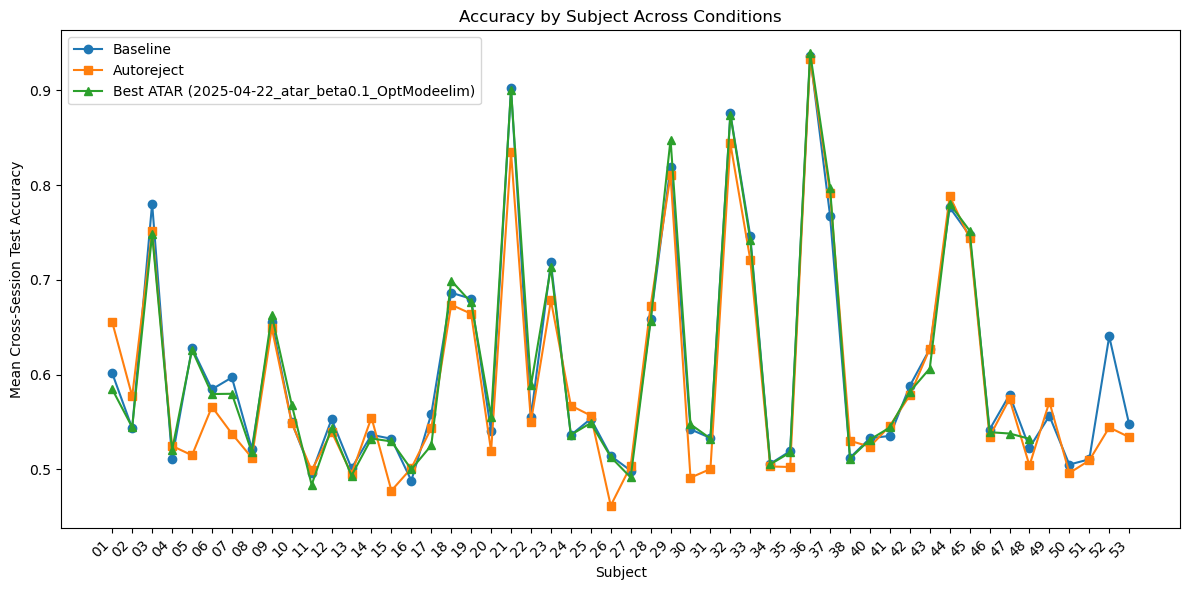

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine cross-session DataFrames if not already combined
df_cross_all = pd.concat(
    [dfs['cross'].assign(source=src) for src, dfs in results.items()],
    ignore_index=True
)

# Identify best ATAR variant
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross_all.groupby('source')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# Prepare mean accuracy per subject for each condition
subjects = sorted(df_cross_all['evaluation'].unique())

baseline_acc = df_cross_all[df_cross_all['source'] == '2025-04-25'] \
    .groupby('evaluation')['test_accuracy'] \
    .mean().reindex(subjects)

autoreject_acc = df_cross_all[df_cross_all['source'] == '2025-04-25_autoreject'] \
    .groupby('evaluation')['test_accuracy'] \
    .mean().reindex(subjects)

atar_acc = df_cross_all[df_cross_all['source'] == best_atar] \
    .groupby('evaluation')['test_accuracy'] \
    .mean().reindex(subjects)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(subjects, baseline_acc, marker='o', label='Baseline')
plt.plot(subjects, autoreject_acc, marker='s', label='Autoreject')
plt.plot(subjects, atar_acc, marker='^', label=f'Best ATAR ({best_atar})')

plt.xlabel('Subject')
plt.ylabel('Mean Cross-Session Test Accuracy')
plt.title('Accuracy by Subject Across Conditions')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


2025-04-30 21:54:04,036 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:04,040 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:04,044 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:04,046 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 21:54:04,

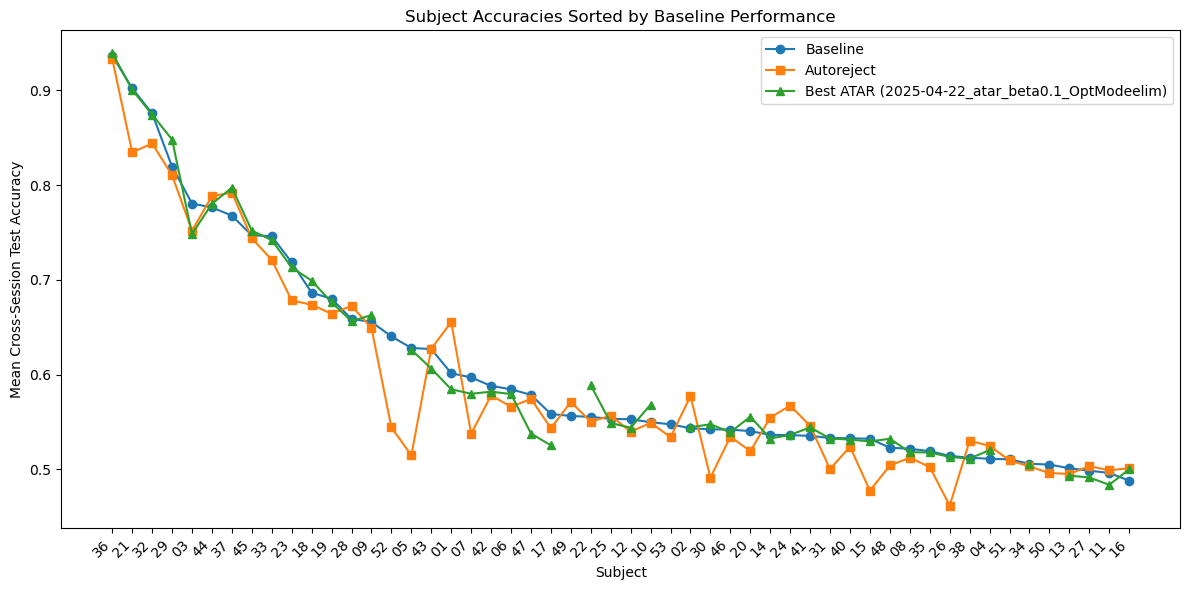

In [9]:

df_cross_all = pd.concat(
    [dfs['cross'].assign(source=src) for src, dfs in results.items()],
    ignore_index=True
)

# 2) Identify best-performing ATAR variant
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross_all.groupby('source')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# 3) Compute mean accuracy per subject for baseline and determine order
baseline_series = (
    df_cross_all[df_cross_all['source'] == '2025-04-25']
    .groupby('evaluation')['test_accuracy']
    .mean()
)
subject_order = baseline_series.sort_values(ascending=False).index.tolist()

# 4) Plot accuracies per subject in sorted order
plt.figure(figsize=(12, 6))

conditions = [
    ('2025-04-25', 'o', 'Baseline'),
    ('2025-04-25_autoreject', 's', 'Autoreject'),
    (best_atar, '^', f'Best ATAR ({best_atar})')
]

for src, marker, label in conditions:
    series = (
        df_cross_all[df_cross_all['source'] == src]
        .groupby('evaluation')['test_accuracy']
        .mean()
        .reindex(subject_order)
    )
    plt.plot(subject_order, series.values, marker=marker, label=label)

plt.xlabel('Subject')
plt.ylabel('Mean Cross-Session Test Accuracy')
plt.title('Subject Accuracies Sorted by Baseline Performance')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


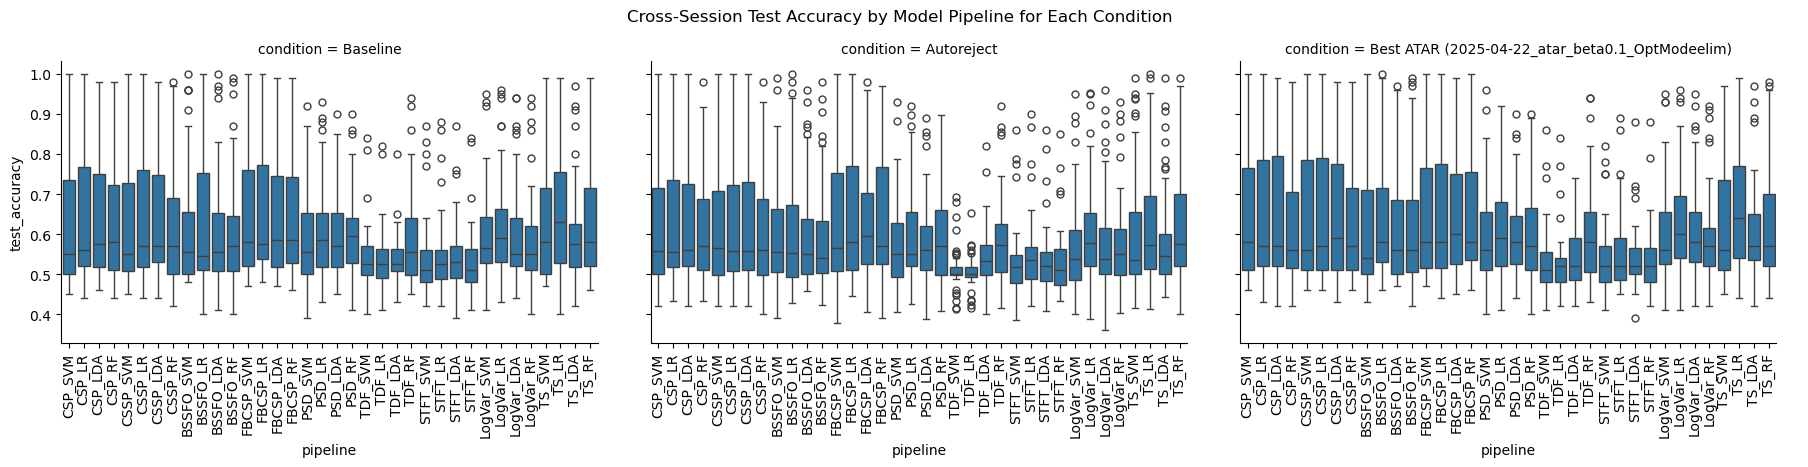

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine cross-session DataFrames
df_cross_all = pd.concat(
    [dfs['cross'].assign(source=src) for src, dfs in results.items()],
    ignore_index=True
)

# Identify best ATAR variant
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross_all.groupby('source')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# Select conditions to compare
compare_sources = ['2025-04-25', '2025-04-25_autoreject', best_atar]
df_cmp = df_cross_all[df_cross_all['source'].isin(compare_sources)].copy()

# Map to readable labels
label_map = {
    '2025-04-25': 'Baseline',
    '2025-04-25_autoreject': 'Autoreject',
    best_atar: f'Best ATAR ({best_atar})'
}
df_cmp['condition'] = df_cmp['source'].map(label_map)

# Plot boxplots of test_accuracy per pipeline, faceted by condition
g = sns.catplot(
    data=df_cmp,
    x='pipeline',
    y='test_accuracy',
    col='condition',
    kind='box',
    height=4,
    aspect=1.5,
    sharey=True
)
g.set_xticklabels(rotation=90)
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Cross-Session Test Accuracy by Model Pipeline for Each Condition')
plt.show()


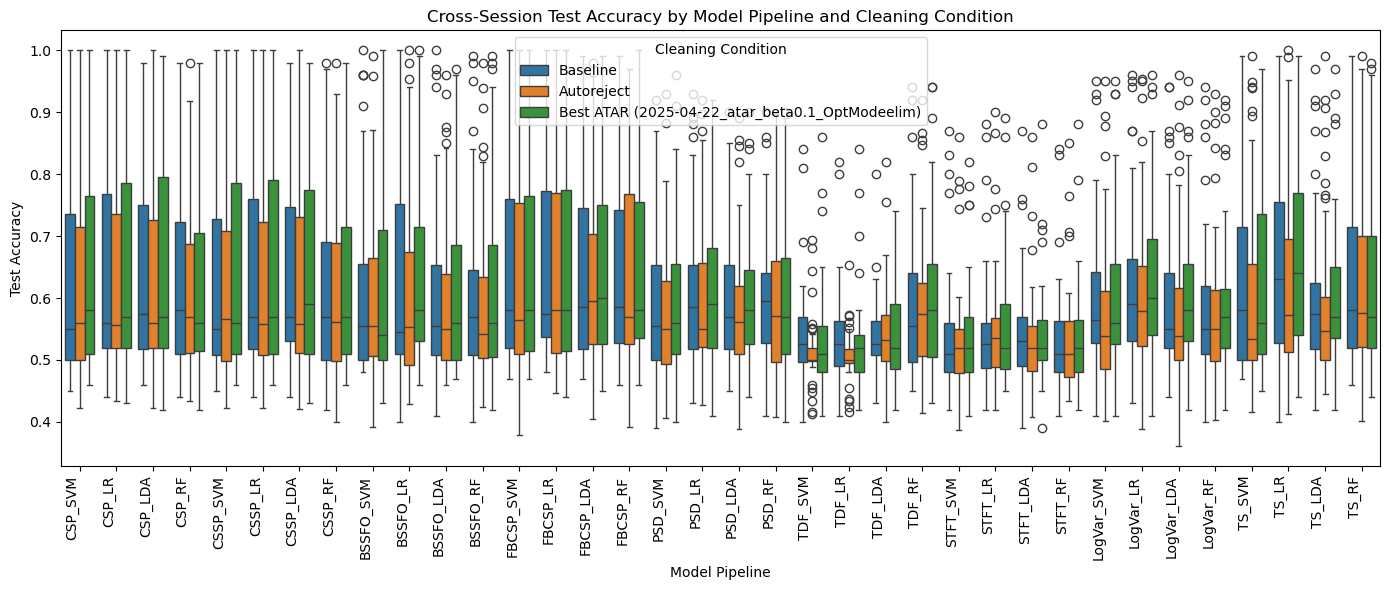

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Combine all cross‐session results into one DataFrame
df_cross_all = pd.concat(
    [dfs['cross'].assign(condition=src) for src, dfs in results.items()],
    ignore_index=True
)

# 2) Identify the best ATAR variant
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross_all.groupby('condition')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# 3) Filter down to the three conditions
keep = ['2025-04-25', '2025-04-25_autoreject', best_atar]
df_cmp = df_cross_all[df_cross_all['condition'].isin(keep)].copy()

# 4) Map folder names to friendly labels
label_map = {
    '2025-04-25':            'Baseline',
    '2025-04-25_autoreject': 'Autoreject',
    best_atar:               f'Best ATAR ({best_atar})'
}
df_cmp['Condition'] = df_cmp['condition'].map(label_map)

# 5) Plot: pipelines on x, test_accuracy on y, hue by Condition
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_cmp,
    x='pipeline',
    y='test_accuracy',
    hue='Condition',
    palette={
        'Baseline':      '#1f77b4',
        'Autoreject':    '#ff7f0e',
        f'Best ATAR ({best_atar})': '#2ca02c'
    },
    dodge=True
)
plt.title("Cross-Session Test Accuracy by Model Pipeline and Cleaning Condition")
plt.xlabel("Model Pipeline")
plt.ylabel("Test Accuracy")
plt.xticks(rotation=90, ha='right')
plt.legend(title="Cleaning Condition")
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# 1) Baseline cross-session DataFrame
df_base = results['2025-04-25']['cross']

# 2) Pipeline ranking by mean test_accuracy
pipeline_means = (
    df_base
    .groupby('pipeline')['test_accuracy']
    .mean()
    .sort_values(ascending=False)
    .rename('mean_test_accuracy')
    .reset_index()
)
print("=== Pipeline Ranking (Baseline) ===")
print(pipeline_means, "\n")

# 3) Extract feature & classifier columns
pipeline_means['feature']    = pipeline_means['pipeline'].str.split('_').str[0]
pipeline_means['classifier'] = pipeline_means['pipeline'].str.split('_').str[1]

# 4) Feature ranking
feature_means = (
    pipeline_means
    .groupby('feature')['mean_test_accuracy']
    .mean()
    .sort_values(ascending=False)
    .rename('feature_mean_accuracy')
    .reset_index()
)
print("=== Feature Ranking (Baseline) ===")
print(feature_means, "\n")

# 5) Classifier ranking
classifier_means = (
    pipeline_means
    .groupby('classifier')['mean_test_accuracy']
    .mean()
    .sort_values(ascending=False)
    .rename('classifier_mean_accuracy')
    .reset_index()
)
print("=== Classifier Ranking (Baseline) ===")
print(classifier_means, "\n")

# 6) Best classifier for each feature
best_per_feature = (
    pipeline_means
    .sort_values('mean_test_accuracy', ascending=False)
    .groupby('feature')
    .first()
    .reset_index()[['feature','classifier','mean_test_accuracy']]
    .rename(columns={'mean_test_accuracy':'best_accuracy'})
)
print("=== Best Classifier per Feature ===")
print(best_per_feature.head(30), "\n")

=== Pipeline Ranking (Baseline) ===
      pipeline  mean_test_accuracy
0        TS_LR            0.662308
1     FBCSP_LR            0.655577
2    FBCSP_LDA            0.647692
3    FBCSP_SVM            0.647500
4     FBCSP_RF            0.644423
5       CSP_LR            0.642692
6     CSSP_LDA            0.641731
7      CSP_LDA            0.640769
8      CSSP_LR            0.640577
9      CSP_SVM            0.635000
10      TS_SVM            0.634038
11    CSSP_SVM            0.632885
12       TS_RF            0.630769
13    BSSFO_LR            0.627692
14      CSP_RF            0.625962
15   LogVar_LR            0.619808
16     CSSP_RF            0.616154
17   BSSFO_SVM            0.612115
18      PSD_LR            0.605962
19    BSSFO_RF            0.604038
20   BSSFO_LDA            0.602308
21      PSD_RF            0.602115
22      TS_LDA            0.601346
23  LogVar_LDA            0.597115
24  LogVar_SVM            0.591731
25     PSD_LDA            0.590192
26   LogVar_RF     

In [17]:
# 7) Top 5 pipelines (distinct features)
selected = []
seen = set()
for _, row in pipeline_means.iterrows():
    if row['feature'] not in seen:
        selected.append(row)
        seen.add(row['feature'])
    if len(selected) == 5:
        break
best5 = pd.DataFrame(selected)[['pipeline','feature','classifier','mean_test_accuracy']]
print("=== Top 5 Pipelines (Distinct Features) ===")
print(best5)

=== Top 5 Pipelines (Distinct Features) ===
    pipeline feature classifier  mean_test_accuracy
0      TS_LR      TS         LR            0.662308
1   FBCSP_LR   FBCSP         LR            0.655577
5     CSP_LR     CSP         LR            0.642692
6   CSSP_LDA    CSSP        LDA            0.641731
13  BSSFO_LR   BSSFO         LR            0.627692


=== Best Classifier for Each Feature ===
  feature classifier   pipeline  mean_test_accuracy
0      TS         LR      TS_LR            0.662308
1   FBCSP         LR   FBCSP_LR            0.655577
2     CSP         LR     CSP_LR            0.642692
3    CSSP        LDA   CSSP_LDA            0.641731
4   BSSFO         LR   BSSFO_LR            0.627692
5  LogVar         LR  LogVar_LR            0.619808
6     PSD         LR     PSD_LR            0.605962
7     TDF         RF     TDF_RF            0.585577
8    STFT         LR    STFT_LR            0.544038


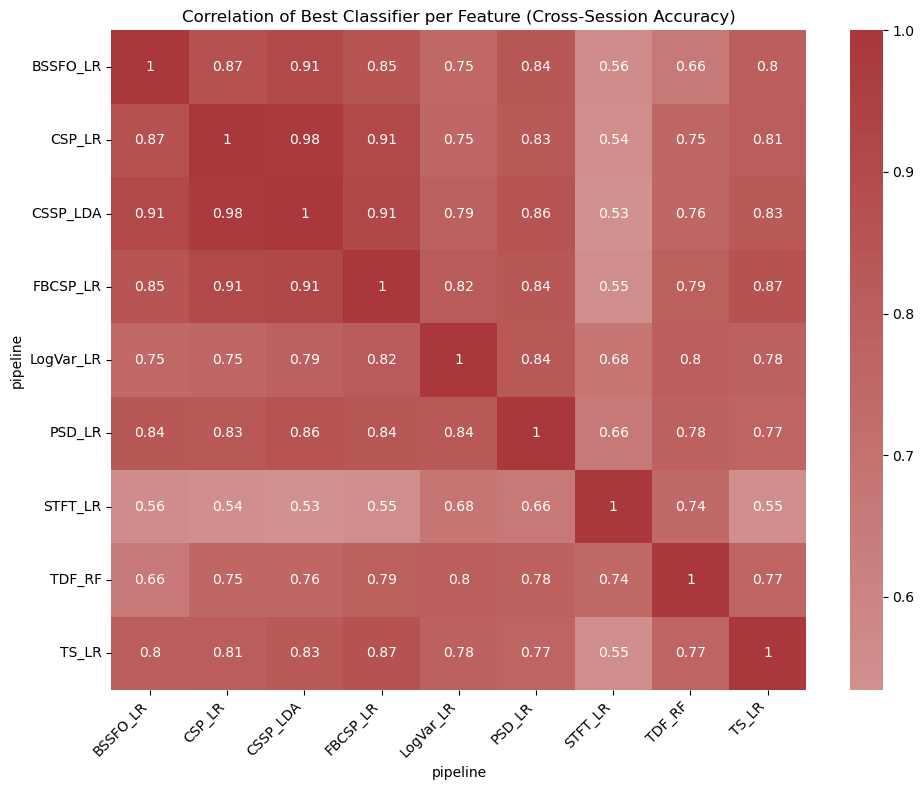

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load cross-session accuracies
df_base = results['2025-04-25']['cross']

# 2) Compute mean accuracy per pipeline
pipeline_means = (
    df_base
    .groupby('pipeline')['test_accuracy']
    .mean()
    .reset_index(name='mean_test_accuracy')
)

# 3) Extract feature & classifier (assumes 'FEATURE_CLASSIFIER' naming)
pipeline_means['feature']    = pipeline_means['pipeline'].str.split('_').str[0]
pipeline_means['classifier'] = pipeline_means['pipeline'].str.split('_').str[1]

# 4) Sort by descending accuracy, then drop duplicates so we keep only the best per feature
best_per_feature = (
    pipeline_means
    .sort_values('mean_test_accuracy', ascending=False)
    .drop_duplicates(subset='feature')
    .reset_index(drop=True)
)

print("=== Best Classifier for Each Feature ===")
print(best_per_feature[['feature','classifier','pipeline','mean_test_accuracy']])

# 5) Pivot only those selected pipelines
selected = best_per_feature['pipeline'].tolist()
df_pivot = (
    df_base[df_base['pipeline'].isin(selected)]
    .pivot(index='evaluation', columns='pipeline', values='test_accuracy')
)

# 6) Compute & plot correlation matrix
df_corr = df_pivot.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='vlag', center=0)
plt.title('Correlation of Best Classifier per Feature (Cross-Session Accuracy)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


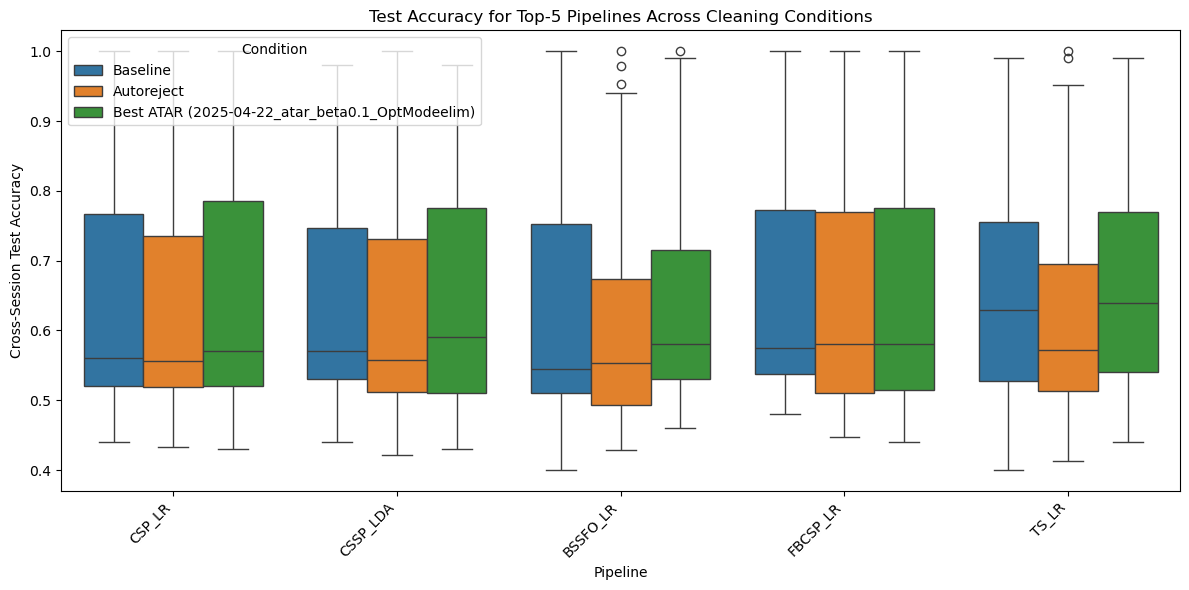

In [22]:

df_cross_all = pd.concat(
    [dfs['cross'].assign(condition=src) for src, dfs in results.items()],
    ignore_index=True
)

# 2) Identify best-performing ATAR variant
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross_all.groupby('condition')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# 3) Build baseline pipeline ranking
df_base = results['2025-04-25']['cross']
pipe_means = (
    df_base
    .groupby('pipeline')['test_accuracy']
    .mean()
    .reset_index(name='mean_test_accuracy')
    .sort_values('mean_test_accuracy', ascending=False)
)
# extract feature
pipe_means['feature'] = pipe_means['pipeline'].str.split('_').str[0]

# 4) Select top 5 distinct-feature pipelines
best5 = []
seen = set()
for _, row in pipe_means.iterrows():
    feat = row['feature']
    if feat not in seen:
        best5.append(row['pipeline'])
        seen.add(feat)
    if len(best5) == 5:
        break

# 5) Filter for just those pipelines and the three conditions
keep_conditions = ['2025-04-25', '2025-04-25_autoreject', best_atar]
df_cmp = df_cross_all[
    df_cross_all['condition'].isin(keep_conditions) &
    df_cross_all['pipeline'].isin(best5)
].copy()

# 6) Map to friendly labels
label_map = {
    '2025-04-25': 'Baseline',
    '2025-04-25_autoreject': 'Autoreject',
    best_atar: f'Best ATAR ({best_atar})'
}
df_cmp['Condition'] = df_cmp['condition'].map(label_map)

# 7) Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_cmp,
    x='pipeline',
    y='test_accuracy',
    hue='Condition',
    dodge=True
)
plt.title("Test Accuracy for Top-5 Pipelines Across Cleaning Conditions")
plt.xlabel("Pipeline")
plt.ylabel("Cross-Session Test Accuracy")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Condition", loc='upper left')
plt.tight_layout()
plt.show()


2025-04-30 22:08:44,097 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 22:08:44,099 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 22:08:44,101 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 22:08:44,103 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-30 22:08:44,

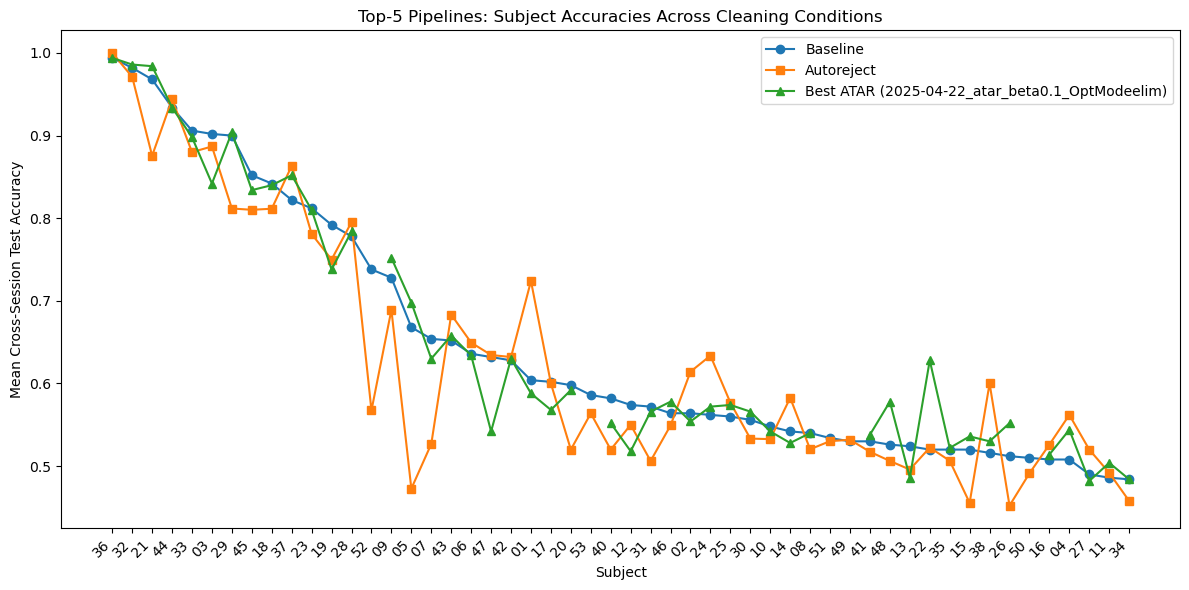

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Combine all cross‐session results
df_cross_all = pd.concat(
    [dfs['cross'].assign(source=src) for src, dfs in results.items()],
    ignore_index=True
)

# 2) Determine your top‐5 distinct‐feature pipelines (based on baseline)
df_base = results['2025-04-25']['cross']
pipe_means = (
    df_base
    .groupby('pipeline')['test_accuracy']
    .mean()
    .reset_index(name='mean_test_accuracy')
    .sort_values('mean_test_accuracy', ascending=False)
)
pipe_means['feature'] = pipe_means['pipeline'].str.split('_').str[0]

best5 = []
seen = set()
for _, row in pipe_means.iterrows():
    feat = row['feature']
    if feat not in seen:
        best5.append(row['pipeline'])
        seen.add(feat)
    if len(best5) == 5:
        break

# 3) Filter the full cross‐session DataFrame down to just those 5 pipelines
df_cross5 = df_cross_all[df_cross_all['pipeline'].isin(best5)].copy()

# 4) Identify which ATAR variant performs best on those pipelines
atar_means = {
    src: grp['test_accuracy'].mean()
    for src, grp in df_cross5.groupby('source')
    if 'atar' in src
}
best_atar = max(atar_means, key=atar_means.get)

# 5) Determine subject ordering by baseline performance (averaged over best5)
baseline_avg = (
    df_cross5[df_cross5['source'] == '2025-04-25']
    .groupby('evaluation')['test_accuracy']
    .mean()
)
subject_order = baseline_avg.sort_values(ascending=False).index.tolist()

# 6) Plot per‐subject mean accuracy for the three conditions
plt.figure(figsize=(12, 6))
for src, marker, label in [
    ('2025-04-25',            'o', 'Baseline'),
    ('2025-04-25_autoreject', 's', 'Autoreject'),
    (best_atar,               '^', f'Best ATAR ({best_atar})')
]:
    series = (
        df_cross5[df_cross5['source'] == src]
        .groupby('evaluation')['test_accuracy']
        .mean()
        .reindex(subject_order)
    )
    plt.plot(subject_order, series.values,
             marker=marker, linestyle='-', label=label)

plt.xlabel('Subject')
plt.ylabel('Mean Cross-Session Test Accuracy')
plt.title('Top-5 Pipelines: Subject Accuracies Across Cleaning Conditions')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
import pandas as pd

# 1) Grab your baseline cross‐session DataFrame
df_base = results['2025-04-25']['cross']

# 2) Determine the top‐5 distinct‐feature pipelines (baseline)
pipe_means = (
    df_base
    .groupby('pipeline')['test_accuracy']
    .mean()
    .reset_index(name='mean_test_accuracy')
    .sort_values('mean_test_accuracy', ascending=False)
)
pipe_means['feature'] = pipe_means['pipeline'].str.split('_').str[0]

best5 = []
seen = set()
for _, row in pipe_means.iterrows():
    feat = row['feature']
    if feat not in seen:
        best5.append(row['pipeline'])
        seen.add(feat)
    if len(best5) == 5:
        break

# 3) Compute each subject’s baseline mean accuracy across those top‐5 pipelines
df_top5 = df_base[df_base['pipeline'].isin(best5)]
subject_means = (
    df_top5
    .groupby('evaluation')['test_accuracy']
    .mean()
    .reset_index(name='baseline_mean_accuracy')
)

# 4) Assign performance groups
def assign_group(acc):
    if acc > 0.9:
        return 'best (>0.9)'
    elif acc > 0.8:
        return 'good (0.8–0.9)'
    elif acc > 0.7:
        return 'average (0.7–0.8)'
    elif acc > 0.6:
        return 'low (0.6–0.7)'
    else:
        return 'illiterate (<0.6)'

subject_means['group'] = subject_means['baseline_mean_accuracy'].apply(assign_group)

# 5) Show the table
print(subject_means)

# 6) (Optional) Count how many subjects in each group
print("\nCounts per group:")
print(subject_means['group'].value_counts())


   evaluation  baseline_mean_accuracy              group
0          01                   0.604      low (0.6–0.7)
1          02                   0.564  illiterate (<0.6)
2          03                   0.902        best (>0.9)
3          04                   0.508  illiterate (<0.6)
4          05                   0.668      low (0.6–0.7)
5          06                   0.636      low (0.6–0.7)
6          07                   0.654      low (0.6–0.7)
7          08                   0.540  illiterate (<0.6)
8          09                   0.728  average (0.7–0.8)
9          10                   0.548  illiterate (<0.6)
10         11                   0.486  illiterate (<0.6)
11         12                   0.574  illiterate (<0.6)
12         13                   0.524  illiterate (<0.6)
13         14                   0.542  illiterate (<0.6)
14         15                   0.520  illiterate (<0.6)
15         16                   0.508  illiterate (<0.6)
16         17                  

In [28]:
subject_means

,evaluation,baseline_mean_accuracy,group
0,01,0.604,low (0.6–0.7)
1,02,0.564,illiterate (<0.6)
2,03,0.902,best (>0.9)
3,04,0.508,illiterate (<0.6)
4,05,0.668,low (0.6–0.7)
5,06,0.636,low (0.6–0.7)
6,07,0.654,low (0.6–0.7)
7,08,0.540,illiterate (<0.6)
8,09,0.728,average (0.7–0.8)
9,10,0.548,illiterate (<0.6)


In [51]:
import pandas as pd

# 1) Aggregate by group
group_summary = (
    subject_means
      .groupby('group')['baseline_mean_accuracy']
      .agg(
           count='count',
           mean_accuracy='mean',
           median_accuracy='median',
           std_accuracy='std'
      )
)

# 2) Compute percentage of total
total = group_summary['count'].sum()
group_summary['percentage'] = (group_summary['count'] / total) * 100

# 3) Sort by mean accuracy if you like
group_summary = group_summary.sort_values('mean_accuracy', ascending=False)

group_summary


,count,mean_accuracy,median_accuracy,std_accuracy,percentage
group,,,,,
best (>0.9),6,0.947667,0.951,0.039363,11.538462
good (0.8–0.9),5,0.845600,0.842,0.034275,9.615385
average (0.7–0.8),4,0.759000,0.758,0.030833,7.692308
low (0.6–0.7),8,0.634500,0.634,0.023440,15.384615
illiterate (<0.6),29,0.536759,0.530,0.030605,55.769231


In [104]:
subject_means.head(10)

,evaluation,baseline_mean_accuracy,group
0,01,0.604,low (0.6–0.7)
1,02,0.564,illiterate (<0.6)
2,03,0.902,best (>0.9)
3,04,0.508,illiterate (<0.6)
4,05,0.668,low (0.6–0.7)
5,06,0.636,low (0.6–0.7)
6,07,0.654,low (0.6–0.7)
7,08,0.540,illiterate (<0.6)
8,09,0.728,average (0.7–0.8)
9,10,0.548,illiterate (<0.6)


In [121]:
low_mean = subject_means[subject_means.group == 'low (0.6–0.7)']
illiterate_mean = subject_means[subject_means.group == 'illiterate (<0.6)']
best_mean = subject_means[subject_means.group == 'best (>0.9)']
average_mean = subject_means[subject_means.group == 'average (0.7–0.8)']
good_mean = subject_means[subject_means.group == 'good (0.8–0.9)']

In [127]:
paths_epo = []

for subject in best_mean.evaluation:
    for run in [1,2]:
        try:
            tfr_path_epo = glob.glob(os.path.join(os.getcwd(), 
                                                  'data','tfr','20',f's{subject:02}.{run:02}**Hz)_tfr_data.h5'))
            # tfr_path_epo = glob.glob(os.path.join(os.getcwd(), 
            #                                       'data','tfr','20',f's{subject:02}.{run:02}**Hz)autore_tfr_data.h5'))
            # tfr_path_epo = glob.glob(os.path.join(os.getcwd(), 
            #                                       'data','tfr','20',f's{subject:02}.{run:02}**Hz)_beta0.1_OptModesoft_tfr_data.h5'))

            # tfr_path_epo = glob.glob(os.path.join(os.getcwd(), 
            #                                       'data','tfr','20',f's{subject:02}.{run:02}**Hz)_beta0.05_OptModesoft_tfr_data.h5'))

            paths_epo.append(tfr_path_epo)
        except Exception as e:
            # Log the error and continue with the next iteration
            log.error(f"Error processing subject {subject}, run {run}")
            log.error(f"Error details: {e}")
            continue
tfr_paths_epo = [path for path in paths_epo if path]



In [128]:
# tfrs = []
tfr_right = []
tfr_left = []
            # events = dict(left_hand=2, right_hand=1)

for tfr_file in tfr_paths_epo:
    tfr = mne.time_frequency.read_tfrs(tfr_file[0])  # Reading the first object from the list
    eid = tfr.event_id.copy()

    if '1' in eid and '2' in eid:
        eid = {
            'left_hand':  eid.pop('2'),
            'right_hand': eid.pop('1')
        }
        tfr.event_id = eid

    tfr_left.append(tfr['left_hand'].average())
    tfr_right.append(tfr['right_hand'].average())
    # tfrs.append(tfr) #


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s03.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s03.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s03.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s03.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s21.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s21.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s21.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s21.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s32.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s32.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s32.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s32.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s33.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s33.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s33.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s33.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s36.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s36.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s36.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s36.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s44.01(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s44.01(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s44.02(-5_10)(8_30Hz)_tfr_data.h5 ...


C:\Users\rokas\AppData\Local\Temp\ipykernel_13988\3908844507.py:7: RuntimeWarning: This filename (c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\tfr\20\s44.02(-5_10)(8_30Hz)_tfr_data.h5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5


In [129]:
grand_tfr_epo_right =  mne.grand_average(tfr_right)
grand_tfr_epo_left =  mne.grand_average(tfr_left)

Identifying common channels ...
Identifying common channels ...


Converting "channel" to "category"...
Converting "ch_type" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


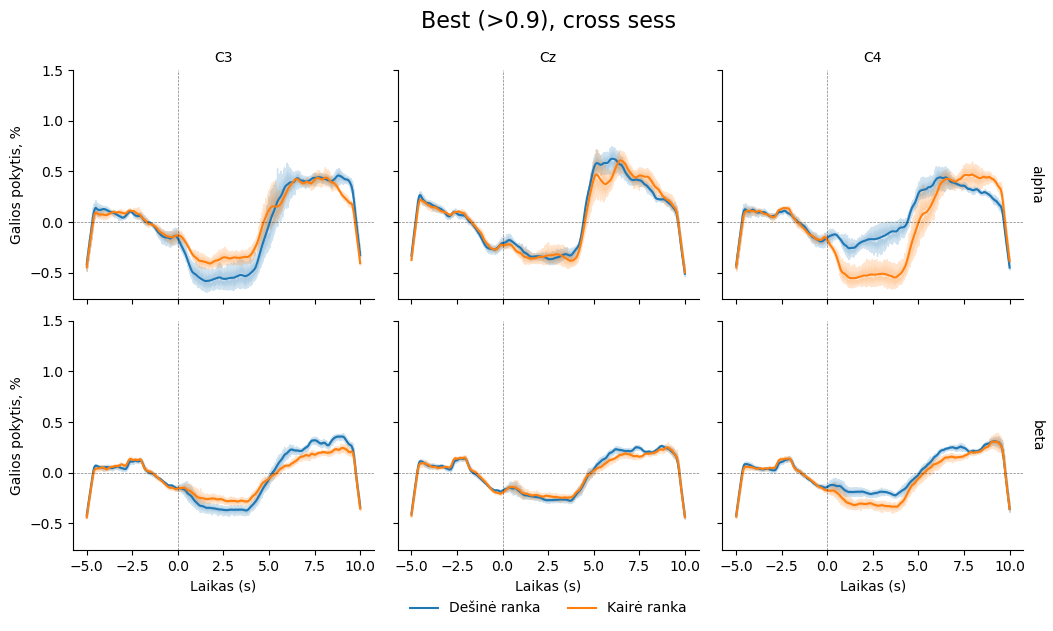

In [130]:
def tfr_lineplot(grand_tfr_left=None, grand_tfr_right=None):
    # Convert TFR to DataFrame in long format

    df = grand_tfr_right.to_data_frame(time_format=None, long_format=True)
    df['condition'] = 'right_hand'

    df_2 = grand_tfr_left.to_data_frame(time_format=None, long_format=True)
    df_2['condition'] = 'left_hand'
    df = pd.concat([df, df_2], ignore_index=True)
    
    freq_bounds = {"_": 7,"alpha": 13, "beta": 30}
    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )
    df = df.dropna()

    df = df[df["channel"].isin(["C3", "Cz", "C4"])].copy()

    df["channel"] = df["channel"].astype("category")
    df["channel"] = df["channel"].cat.set_categories(["C3", "Cz", "C4"], ordered=True)

    df['condition'] = df['condition'].replace({'left_hand': 'Kairė ranka', 'right_hand': 'Dešinė ranka'})
    
    # Create the FacetGrid plot
    g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
    g.map(sns.lineplot, "time", "value", "condition", n_boot=10)

    # Add vertical and horizontal reference lines
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)

    # Set plot limits and labels
    g.set(ylim=(None, 1.5))
    g.set_axis_labels("Laikas (s)", "Galios pokytis, %")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    
    # Add a legend
    g.add_legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.05))
    
    # Adjust the subplot layout
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    
    # Save the plot if requested
    g.fig.suptitle("Best (>0.9), cross sess", fontsize=16)
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.88, bottom=0.08)
    
    plt.show()
    # Close the plot to avoid memory issues with multiple plots
    plt.close()

tfr_lineplot(grand_tfr_left=grand_tfr_epo_left, grand_tfr_right=grand_tfr_epo_right)